# Training CNNs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: podcast-o-rybach (podcast-o-rybach-warsaw-university-of-technology). Use `wandb login --relogin` to force relogin


True

### Use GPU if available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Pytorch transformations for loading the data

In [3]:
def load_dataset(name, input_resolution):
    if name == 'FER2013':
        mean, std = (0.5, ), (0.5, )
    elif name == 'EuroSAT':
        mean, std = (0.5, ), (0.5, )
    elif name == 'FashionMNIST':
        mean, std = (0.286, ), (0.338, )
    elif name == 'imagenette':
        mean, std = (0.462, 0.458, 0.430), (0.270, 0.267, 0.290)
    elif name == 'imagewoof':
        mean, std = (0.486, 0.456, 0.394), (0.248, 0.241, 0.250)
    input_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((input_resolution, input_resolution)),
        transforms.Normalize(mean, std)
    ])
    if name == 'FER2013':
        trainset = torchvision.datasets.FER2013(
            './data',
            transform=input_transform
        )
        valset = torchvision.datasets.FER2013(
            './data',
            transform=input_transform,
            split='test'
        )
        is_grayscale = True
        class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    if name == 'FashionMNIST':
        trainset = torchvision.datasets.FashionMNIST(
            './data',
            train=True,
            download=True,
            transform=input_transform
        )
        valset = torchvision.datasets.FashionMNIST(
            './data',
            train=False,
            download=True,
            transform=input_transform
        )
        is_grayscale = True
        class_names = trainset.classes
    elif name == 'EuroSAT':
        dataset = torchvision.datasets.EuroSAT(
            './data',
            download=True,
            transform=input_transform
        )
        trainset, valset = torch.utils.data.random_split(dataset, [0.8, 0.2])
        is_grayscale = False
        class_names = dataset.classes
    elif name == 'imagewoof':
        trainset = torchvision.datasets.ImageFolder(
            './data/imagewoof2-160/train',
            transform=input_transform
        )
        valset = torchvision.datasets.ImageFolder(
            './data/imagewoof2-160/val',
            transform=input_transform
        )
        is_grayscale = False
        class_names = trainset.classes
    elif name == 'imagenette':
        trainset = torchvision.datasets.Imagenette(
            './data/imagenette_train',
            split='train',
            size='160px',
            transform=input_transform
        )
        valset = torchvision.datasets.Imagenette(
            './data/imagenette_val',
            split='val',
            size='160px',
            transform=input_transform
        )
        is_grayscale = False
        class_names = trainset.classes
    return trainset, valset, is_grayscale, class_names


### Define the model, loss function and optimizer

In [ ]:
class OurCNN(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNN, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 96, 3)
        self.conv3 = nn.Conv2d(96, 128, 3)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 4 * 4, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool_last(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class OurCNNDropout(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 96, 3)
        self.conv3 = nn.Conv2d(96, 128, 3)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 4 * 4, 200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool_last(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout1(x)))
        x = self.fc3(self.dropout2(x))
        return x

class OurCNNBatchNormAfterConvs(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNNBatchNormAfterConvs, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 5, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 96, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 128, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 4 * 4, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool_last(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class OurCNNBatchNorm(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNNBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 5, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 96, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 128, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 4 * 4, 200, bias=False)
        self.bnfc1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 100, bias=False)
        self.bnfc2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool_last(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.bnfc1(self.fc1(x)))
        x = F.relu(self.bnfc2(self.fc2(x)))
        x = self.fc3(x)
        return x

class OurCNNVGGLike(nn.Module):
    def __init__(self, input_is_grayscale, num_outputs):
        super(OurCNNVGGLike, self).__init__()
        self.conv1 = nn.Conv2d(1 if input_is_grayscale else 3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 96, 3)
        self.conv4 = nn.Conv2d(96, 96, 3)
        self.conv5 = nn.Conv2d(96, 96, 3, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 128, 3)
        self.conv7 = nn.Conv2d(128, 128, 3, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool_last = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(128 * 3 * 3, 200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv2(self.conv1(x)))))
        x = self.pool(F.relu(self.bn2(self.conv5(self.conv4(self.conv3(x))))))
        x = self.pool_last(F.relu(self.bn3(self.conv7(self.conv6(x)))))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout1(x)))
        x = self.fc3(self.dropout2(x))
        return x

### Train. Save loss and accuracy for train and validation

In [5]:
def train(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs):

    model.to(device)
    PRINT_STEP = len(trainloader) // 5 - 1

    for epoch in range(0, num_epochs):
        print(f'Epoch {epoch}')
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predictions = torch.max(outputs.data, 1)
            correct += (predictions == labels).float().mean().item()

            running_loss += loss.item()
            if i % PRINT_STEP == PRINT_STEP-1:
                accuracy = correct / PRINT_STEP
                loss = running_loss / PRINT_STEP
                step = epoch * len(trainloader) + i
                wandb.log({
                        "train/accuracy": accuracy,
                        "train/loss": loss
                    },
                    step=step
                )
                running_loss = 0.0
                correct = 0

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for j, data in enumerate(valloader, 0):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                val_correct += (predictions == labels).float().mean().item()

        accuracy = val_correct / len(valloader)
        loss = val_loss / len(valloader)
        wandb.log({
                "validation/accuracy": accuracy,
                "validation/loss": loss
            },
            step = (epoch + 1) * len(trainloader)
        )
        model.train()
        scheduler.step()

    print('Finished Training')

In [ ]:
LR_DECAY = 0.95
MOMENTUM = 0.9
LEARNING_RATE = 0.03
OPTMIZER = optim.SGD

for MODEL in [OurCNNVGGLike, OurCNNDropout, OurCNNBatchNormAfterConvs, OurCNNBatchNorm]:
    for DATASET_NAME in ['imagenette', 'imagewoof']:
        if MODEL == OurCNNBatchNormAfterConvs and DATASET_NAME != 'imagewoof':
            continue
        if DATASET_NAME == 'imagewoof':
            LEARNING_RATE = 0.01
        INPUT_RESOLUTION = 80
        trainset, valset, input_is_grayscale, class_names = load_dataset(
            DATASET_NAME, INPUT_RESOLUTION
        )
        trainloader = torch.utils.data.DataLoader(
            trainset,
            batch_size=64,
            num_workers=2,
            shuffle=True
        )
        valloader = torch.utils.data.DataLoader(
            valset,
            batch_size=64,
            shuffle=False,
            num_workers=2
        )
        print(f'Found {len(trainloader)} train and {len(valloader)} val batches')
        print(f'classes: {class_names}')

        model = MODEL(input_is_grayscale, len(class_names))
        criterion = nn.CrossEntropyLoss()
        optimizer = OPTMIZER(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY)
        num_learnable_parameters = sum([
            p.numel() for p in model.parameters() if p.requires_grad
        ])
        print(f'{num_learnable_parameters} learnable parameters')
        wandb.init(
            project="iml_lab2",
            config={
                "learning_rate": LEARNING_RATE,
                "learning_rate_decay": LR_DECAY,
                "momentum": MOMENTUM,
                "batch_size": trainloader.batch_size,
                "input_resolution": INPUT_RESOLUTION,
                "num_parameters": num_learnable_parameters,
                "optimizer": OPTMIZER.__name__,
                "architecture": MODEL.__name__,
                "dataset": DATASET_NAME
            }
        )
        train(model, trainloader, valloader, criterion, optimizer, scheduler, 30)

Found 148 train and 62 val batches
classes: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
770494 learnable parameters


train/accuracy,▁▆█
train/loss,█▂▁
train/accuracy,0.69682
train/loss,0.8246


Epoch 0
Epoch 1
Epoch 2


### Calculate means and standard deviations for Normalize

In [12]:
for DATASET_NAME in ['FashionMNIST', 'imagenette', 'imagewoof']:
    mean, std = 0.0, 0.0
    num_samples = 0
    INPUT_RESOLUTION = 80
    trainset, valset, input_is_grayscale, class_names = load_dataset(
        DATASET_NAME, INPUT_RESOLUTION
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=64,
        num_workers=2,
        shuffle=True
    )
    for i, data in enumerate(trainloader):
        inputs, labels = data
        mean = inputs.numpy().mean(axis=(0, 2, 3)) * inputs.shape[0] + mean
        std = np.std(inputs.numpy(), axis=(0, 2, 3)) * inputs.shape[0] + std
        num_samples += inputs.shape[0]
    print(f'{DATASET_NAME}:')
    print(mean / num_samples)
    print(std / num_samples)


FashionMNIST:
[0.28594527]
[0.3380673]
imagenette:
[0.46247163 0.45796242 0.42979676]
[0.27013233 0.26697868 0.29031703]
imagewoof:
[0.4860626  0.45593935 0.39390635]
[0.24799196 0.2409045  0.24982297]


### Plot a confusion matrix

In [10]:
model.eval()
y_true = []
y_predicted = []
with torch.no_grad():
    for j, data in enumerate(valloader, 0):
        inputs, labels = data
        y_true.extend(labels.numpy())
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        y_predicted.extend(predictions.cpu().numpy())
model.train()


confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_true,
    preds=y_predicted,
    class_names=class_names
)
wandb.log({
    "conf_mat" : confusion_matrix
})


### Save example images

In [ ]:
for DATASET_NAME in ['imagenette', 'imagewoof']:
    table_data = []
    if DATASET_NAME == 'imagenette':
        train_dir = 'data/imagenette_train/imagenette2-160/train'
    elif DATASET_NAME == 'imagewoof':
        train_dir = 'data/imagewoof2-160/train'
    trainset, valset, input_is_grayscale, actual_class_names = load_dataset(
        DATASET_NAME, 80
    )
    for i, class_name in enumerate(os.listdir(train_dir)):
        for file_name in os.listdir(train_dir + '/' + class_name)[:10]:
            if not file_name.endswith('png'):
                continue
            filepath = f'{train_dir}/{class_name}/{file_name}'
            table_data.append([file_name, actual_class_names[i], wandb.Image(filepath)])
    columns = ["filename", "class", "image"]
    test_table = wandb.Table(data=table_data, columns=columns)
    wandb.log(f'example_samples_{DATASET_NAME}', test_table)

In [42]:
misclassified_data = []
model.eval()
with torch.no_grad():
    for j, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs.data, 1)
        val_correct += (predictions == labels).float().mean().item()
        for i in np.argwhere((predictions != labels).cpu().numpy()):
            np_image = inputs[i].cpu().numpy()[0]
            misclassified_data.append((
                np_image,
                predictions[i].item(),
                labels[i].item()
            ))

model.train()

OurCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=7, bias=True)
)

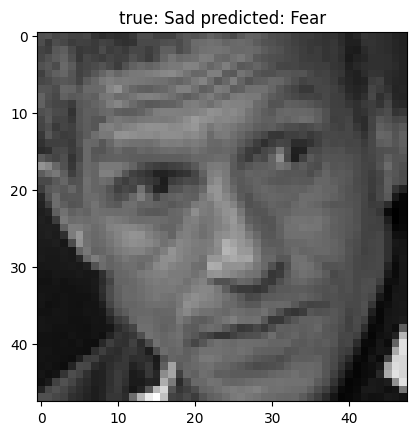

In [58]:
images, labels = next(dataiter)

for image, true_label, selected_label in misclassified_data[11:12]:
    plt.imshow(np.transpose(image / 2 + 0.5, (1, 2, 0)), cmap='grey')
    plt.title(f'true: {class_names[true_label]} predicted: {class_names[selected_label]}')


In [33]:
print(image.shape)

(1, 1, 48, 48)


In [25]:
misclassified_data[0]

(array([[[[ 0.22352946,  0.4431373 ,  0.5529412 , ...,  0.2313726 ,
            0.20784318,  0.17647064],
          [ 0.14509809,  0.427451  ,  0.56078434, ...,  0.26274514,
            0.20784318,  0.17647064],
          [ 0.05882359,  0.3803922 ,  0.5294118 , ...,  0.2941177 ,
            0.26274514,  0.21568632],
          ...,
          [-0.78039217, -0.8039216 , -0.8352941 , ...,  0.4039216 ,
            0.37254906,  0.35686278],
          [-0.77254903, -0.85882354, -0.827451  , ...,  0.38823533,
            0.34901965,  0.32549024],
          [-0.8352941 , -0.8901961 , -0.81960785, ...,  0.34901965,
            0.30980396,  0.26274514]]]], dtype=float32),
 4,
 1)